### Encoder
- BackwardDifferenceEncoder

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils.base_models import BaseModels
from utils.categorical_encoders import CategoricalEncoders

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [37]:
# 0. Definir seed
seed = 16
np.random.seed(seed)

In [38]:
# 1. Leer el dataset
DATASET_PATH = 'data/dataset.csv'
dataset = pd.read_csv(DATASET_PATH, encoding='latin-1' ,sep=';')

In [39]:
# 2. Crear dataset con los encoders
categorical_encoders = CategoricalEncoders(dataset=dataset)
binary_columns, categorical_columns = categorical_encoders.get_binary_categorical_columns()

data = categorical_encoders.provider(binary_columns, categorical_columns, method='BackwardDifferenceEncoder')

In [40]:
# 3. Split dataset
X = data.drop(columns=['Target'])
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [41]:
# 4. Entrenar modelos
base_models = BaseModels()
name_models = ['logistic_regression', 'gradient_boosting', 'catboost', 'lgbm', 'xgboost', 'mlp', 'decision_tree']

all_models = []
all_results = []
all_predict_test = []
for i, model_name in enumerate(name_models):
    model = base_models.provider(model_name)
    model.fit(X_train, y_train)
    all_models.append(model)
    
    predict_train = model.predict_proba(X_train)[:, 1]
    predict_test = model.predict_proba(X_test)[:, 1]
    all_predict_test.append(predict_test)

    train_auc = roc_auc_score(y_train, predict_train)
    test_auc = roc_auc_score(y_test, predict_test)

    all_results.append((model_name, train_auc, test_auc))

    print(f"{str(i).zfill(2)}: AUC on training data with {model_name}: {train_auc:.3f}")
    print(f"AUC on testing data with {model_name}: {test_auc:.3f}\n")

names, train_aucs, test_aucs = zip(*all_results)

00: AUC on training data with logistic_regression: 0.811
AUC on testing data with logistic_regression: 0.779

01: AUC on training data with gradient_boosting: 0.842
AUC on testing data with gradient_boosting: 0.768

02: AUC on training data with catboost: 0.935
AUC on testing data with catboost: 0.768

[LightGBM] [Info] Number of positive: 300, number of negative: 6500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 6800, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044118 -> initscore=-3.075775
[LightGBM] [Info] Start training from score -3.075775
03: AUC on training data with lgbm: 0.949
AUC on testing data with lgbm: 0.750

04: AUC on training data with xgboost: 0.961
AUC on testing data

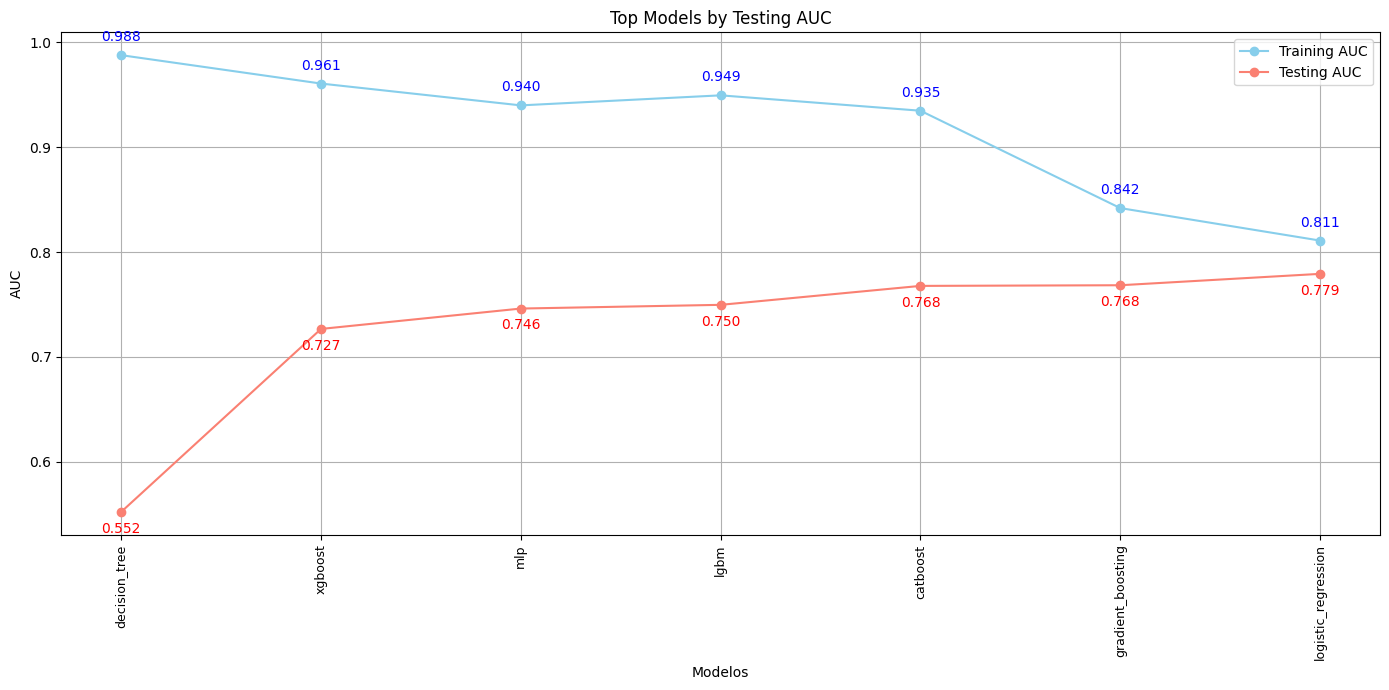

In [42]:

# Ordenar los resultados
sorted_results = sorted(all_results, key=lambda x: x[2], reverse=False)
top_results = sorted_results[:15]

# Desempaquetar los resultados del top
top_names, top_train_aucs, top_test_aucs = zip(*top_results)

plt.figure(figsize=(14, 7))

# Gráfico de líneas para el top
plt.plot(top_names, top_train_aucs, label='Training AUC', marker='o', color='skyblue')
plt.plot(top_names, top_test_aucs, label='Testing AUC', marker='o', color='salmon')

# Añadir los valores a los puntos
for i, txt in enumerate(top_train_aucs):
    plt.annotate(f'{txt:.3f}', (top_names[i], top_train_aucs[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
for i, txt in enumerate(top_test_aucs):
    plt.annotate(f'{txt:.3f}', (top_names[i], top_test_aucs[i]), textcoords="offset points", xytext=(0, -15), ha='center', color='red')

plt.xlabel('Modelos')
plt.ylabel('AUC')
plt.title('Top Models by Testing AUC')
plt.xticks(rotation=90, fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Ensamble
1. logistic_regression
2. gradient_boosting 
3. catboost
4. lgbm
5. xgboost

#### A. Voting

In [54]:
model = VotingClassifier(estimators=[(name_models[0], all_models[0])
                                    ,(name_models[1], all_models[1])
                                    ,(name_models[2], all_models[2])]
                                    , voting='hard')
model.fit(X_train,y_train)

VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(random_state=42)),
                             ('gradient_boosting',
                              GradientBoostingClassifier(random_state=42)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x3458c2af0>)])

In [55]:
VotingClassifier_test_pred = model.predict(X_test)
print("Accuracy on testing: {:.3f}".format(accuracy_score(y_test, VotingClassifier_test_pred)))

finalpred_Averaging = (all_predict_test[0]+all_predict_test[1]+all_predict_test[2])/3
print("auc on testing in Averaging  data : {:.3f}".format(roc_auc_score(y_test, finalpred_Averaging)))

finalpred_W_Averaging = (all_predict_test[0]*0.5+all_predict_test[1]*0.2+all_predict_test[2]*0.3)/3
print("auc on testing in Weighted Average  data : {:.3f}".format(roc_auc_score(y_test, finalpred_W_Averaging)))

Accuracy on testing: 0.963
auc on testing in Averaging  data : 0.777
auc on testing in Weighted Average  data : 0.780


In [56]:
model = VotingClassifier(estimators=[(name_models[0], all_models[0])
                                    ,(name_models[1], all_models[1])
                                    ,(name_models[2], all_models[2])
                                    ,(name_models[3], all_models[3])
                                    ,(name_models[4], all_models[4])]
                                    , voting='hard')
model.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 300, number of negative: 6500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 6800, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044118 -> initscore=-3.075775
[LightGBM] [Info] Start training from score -3.075775


VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(random_state=42)),
                             ('gradient_boosting',
                              GradientBoostingClassifier(random_state=42)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x3458c2af0>),
                             ('lgbm', LGBMClassifier(random_state=42)),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))])

In [57]:
VotingClassifier_test_pred = model.predict(X_test)
print("Accuracy on testing: {:.3f}".format(accuracy_score(y_test, VotingClassifier_test_pred)))

finalpred_Averaging = (all_predict_test[0]+all_predict_test[1]+all_predict_test[2])/3
print("auc on testing in Averaging  data : {:.3f}".format(roc_auc_score(y_test, finalpred_Averaging)))

finalpred_W_Averaging = (all_predict_test[0]*0.5+all_predict_test[1]*0.2+all_predict_test[2]*0.3)/3
print("auc on testing in Weighted Average  data : {:.3f}".format(roc_auc_score(y_test, finalpred_W_Averaging)))

Accuracy on testing: 0.962
auc on testing in Averaging  data : 0.777
auc on testing in Weighted Average  data : 0.780


#### B. Stacking

In [62]:
estimators=[(name_models[0], all_models[0]),
            (name_models[1], all_models[1]),
            (name_models[2], all_models[2])]

stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('logistic_regression',
                                LogisticRegression(random_state=42)),
                               ('gradient_boosting',
                                GradientBoostingClassifier(random_state=42)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x3458c2af0>)],
                   final_estimator=LogisticRegression())

In [63]:
stacking_test_pred = stacking.predict(X_test)
stacking_test_prod = stacking.predict_proba(X_test)[:,1]

# Print scores on both
print("accuracy on testing in Stacking  data : {:.3f}".format(accuracy_score(y_test, stacking_test_pred))) 
print("auc on testing in Stacking  data : {:.3f}".format(roc_auc_score(y_test, stacking_test_prod)))  

accuracy on testing in Stacking  data : 0.961
auc on testing in Stacking  data : 0.778


In [ ]:
estimators=[(name_models[0], all_models[0]),
            (name_models[1], all_models[1]),
            (name_models[2], all_models[2]),
            (name_models[3], all_models[3]),
            (name_models[4], all_models[4])
            ]

stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking.fit(X_train, y_train)

In [65]:
stacking_test_pred = stacking.predict(X_test)
stacking_test_prod = stacking.predict_proba(X_test)[:,1]

# Print scores on both
print("accuracy on testing in Stacking  data : {:.3f}".format(accuracy_score(y_test, stacking_test_pred))) 
print("auc on testing in Stacking  data : {:.3f}".format(roc_auc_score(y_test, stacking_test_prod)))  

accuracy on testing in Stacking  data : 0.962
auc on testing in Stacking  data : 0.778


#### C. Bagging

In [68]:
bagging = BaggingClassifier(n_estimators=50,random_state=0)
bagging.fit(X_train, y_train)

bagging_test_pred = bagging.predict(X_test)
bagging_test_prob = bagging.predict_proba(X_test)[:,1]

# Print scores on both
print("accuracy on testing in BaggingClassifier  data : {:.3f}"
      .format(accuracy_score(y_test, bagging_test_pred))) 
print("auc on testing in BaggingClassifier  data : {:.3f}"
      .format(roc_auc_score(y_test, bagging_test_prob))) 

accuracy on testing in BaggingClassifier  data : 0.952
auc on testing in BaggingClassifier  data : 0.666


In [72]:
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(estimator=base_model, n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)

predict_train = bagging_model.predict_proba(X_train)[:, 1]
predict_test = bagging_model.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, predict_train)
test_auc = roc_auc_score(y_test, predict_test)

print(f"AUC on training data with Bagging: {train_auc:.3f}")
print(f"AUC on testing data with Bagging: {test_auc:.3f}")

AUC on training data with Bagging: 0.981
AUC on testing data with Bagging: 0.660


In [74]:
# Votting Model
voting_model = VotingClassifier(estimators=[(name_models[0], all_models[0]),
                                            (name_models[1], all_models[1]),
                                            (name_models[2], all_models[2])],
                                voting='soft')
voting_model.fit(X_train, y_train)

# Stacking Model
estimators = [(name_models[0], all_models[0]),
              (name_models[1], all_models[1]),
              (name_models[2], all_models[2])]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)

# Bagging Model
bagging_model = BaggingClassifier(estimator=all_models[0], n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)

# Evaluar modelos de ensamble
ensemble_models = [('Voting', voting_model), ('Stacking', stacking_model), ('Bagging', bagging_model)]

for name, model in ensemble_models:
    predict_train = model.predict_proba(X_train)[:, 1]
    predict_test = model.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, predict_train)
    test_auc = roc_auc_score(y_test, predict_test)

    print(f"AUC on training data with {name}: {train_auc:.3f}")
    print(f"AUC on testing data with {name}: {test_auc:.3f}\n")

AUC on training data with Voting: 0.893
AUC on testing data with Voting: 0.777

AUC on training data with Stacking: 0.851
AUC on testing data with Stacking: 0.778

AUC on training data with Bagging: 0.811
AUC on testing data with Bagging: 0.778

